In [90]:
import numpy as np
import pandas as pd
import geoplot as gplt
import geoplot.crs as gcrs
import geopandas as gpd
import shapely
from shapely.geometry import Point,Polygon
import matplotlib.pyplot as plt

In [91]:
nyc_map = gpd.read_file('/Users/krishna-mac/Desktop/CitadelDataOpen/Map/geo_export_aef695bc-13cc-4e8c-b773-e2fc7ebcae80.shp')

In [92]:
nyc_311 = pd.read_csv('/Users/krishna-mac/Desktop/CitadelDataOpen/Data2/New_York_NY_311.csv')

/var/folders/5r/_x41b2p560v3csbcs3l26vlc0000gn/T/ipykernel_57584/603352372.py:1: DtypeWarning: Columns (8,18,29,30) have mixed types. Specify dtype option on import or set low_memory=False.
  nyc_311 = pd.read_csv('/Users/krishna-mac/Desktop/CitadelDataOpen/Data2/New_York_NY_311.csv')


In [93]:
nyc_311 = nyc_311[['Complaint Type','Latitude','Longitude']]
nyc_311['keep'] = nyc_311.apply(lambda row: 0 if(row.Longitude < -74.2555913 or row.Longitude > -73.70000906 or row.Latitude < 40.4961154 or row.Latitude > 40.91553278) else 1, axis=1)
nyc_311 = nyc_311.query("keep == 1")

In [94]:
nyc_311 = nyc_311.dropna()
nyc_graffiti = nyc_311[nyc_311['Complaint Type'] == 'Noise - Street/Sidewalk']
geometry = [Point(xy) for xy in zip(nyc_graffiti['Longitude'],nyc_graffiti['Latitude'])]
crs = 'EPSG:4326'
geo_df = gpd.GeoDataFrame(nyc_graffiti, crs = crs, geometry = geometry)
geo_df = geo_df.dropna()

In [95]:
# total area for the grid
xmin, ymin, xmax, ymax= geo_df.total_bounds

# how many cells across and down
n_cells = 100
cell_size = (xmax-xmin)/n_cells

# projection of the grid
crs = "+proj=sinu +lon_0=0 +x_0=0 +y_0=0 +a=6371007.181 +b=6371007.181 +units=m +no_defs"

# create the cells in a loop
grid_cells = []
for x0 in np.arange(xmin, xmax+cell_size, cell_size ):
    for y0 in np.arange(ymin, ymax+cell_size, cell_size):
        # bounds
        x1 = x0-cell_size
        y1 = y0+cell_size
        grid_cells.append( shapely.geometry.box(x0, y0, x1, y1)  )

cell = gpd.GeoDataFrame(grid_cells, columns=['geometry'], crs=crs)

<AxesSubplot:>

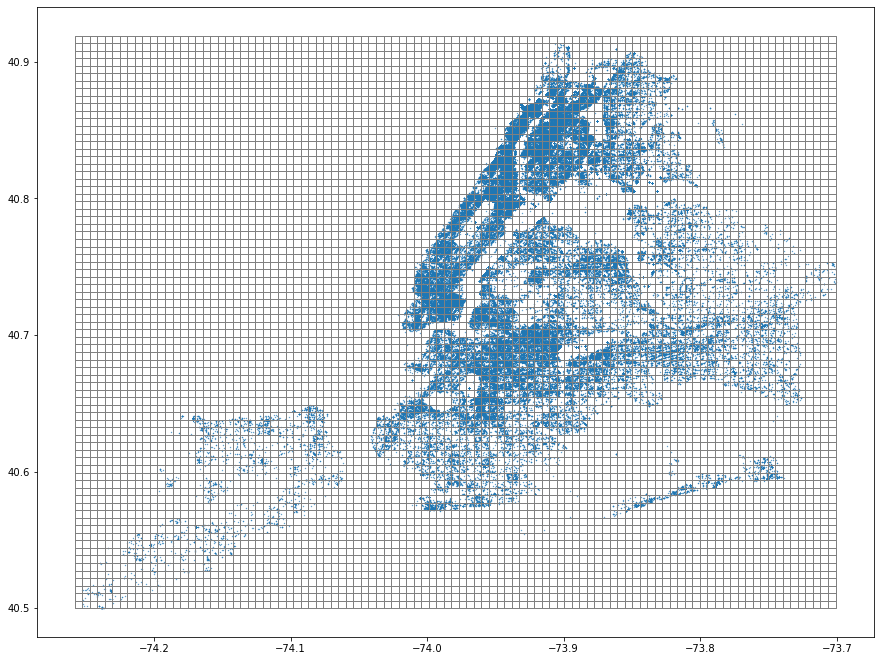

In [96]:
ax = geo_df.plot(markersize = .1, figsize=(15,15))
cell.plot(ax=ax, facecolor="none", edgecolor='grey')

In [97]:
geo_df = geo_df.drop(columns=['Complaint Type','Latitude','Longitude'])
merged = gpd.sjoin(geo_df, cell, how='left', op='within')

/Users/krishna-mac/miniforge3/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3301: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):
/var/folders/5r/_x41b2p560v3csbcs3l26vlc0000gn/T/ipykernel_57584/1107956663.py:2: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:4326
Right CRS: +proj=sinu +lon_0=0 +x_0=0 +y_0=0 +a=6371007.181 + ...

  merged = gpd.sjoin(geo_df, cell, how='left', op='within')


In [98]:
merged['n_graf'] = 1

In [99]:
dissolve = merged.dissolve(by="index_right", aggfunc="count")

In [100]:
cell.loc[dissolve.index, 'n_graf'] = dissolve.n_graf.values

<AxesSubplot:>

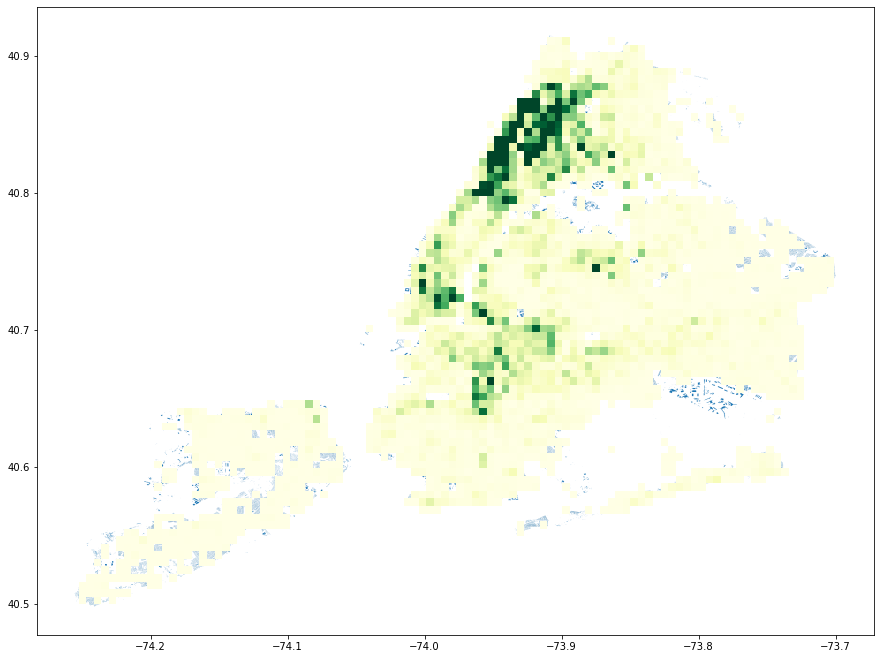

In [110]:
ax = nyc_map.plot(figsize=(15,15))
cell.plot(ax=ax, column='n_graf', cmap='YlGn', vmax=1800)